# Assignment 2
**Due date** December 6th, 2024.

Please fo not forget to add your names, student IDs, and emails in this file.<br>
**Only submit one file per team**

<a target="_blank" href="https://colab.research.google.com/github/ChemAI-Lab/Math4Chem/blob/main/website/Assigments/assigment_1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# load the required libraries that you will need for this assignment
#  [5 marks]
# loading any libraries in other cells will deduct you marks.
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

## (Q1) Linear Regression
* For **Q1** you are only allowed to ude Numpy, Pandas, and Matplotlib, if you use any other libraries you will not get full marks.<br>
<br>

To Do: Write an introduction to the linear regression. <br>

The following data is based on a Polynomial expansion to predict the electronic energy of methane for different geometries. <br>
We will follow the work presented in the paper, [paper link](https://pubs.acs.org/doi/full/10.1021/acs.jctc.9b00043)<br>
"*Using Gradients in Permutationally Invariant Polynomial Potential Fitting: A Demonstration for CH4 Using as Few as 100 Configurations*".

The main idea is to expand the inter-atomic distance of the 5 atoms in terms on a polynomial expansion,
$$
y = \sum^{np}_{i} w_i \phi_i(\mathbf{r})
$$
where $w_i$ are the weights, $\phi_i$ are the Permutationally Invariant Polynomial expansion, and $\mathbf{r}$ are the inter-atomic distances. 

In the dataset provided, the values of the vector $\mathbf{\phi}(\mathbf{r})^\top = [\phi_0(\mathbf{r}),\cdots,\phi_{np}(\mathbf{r})]$, are in each column of a raw, with the respective energy in the last column. 


## (Q1.A) Data preprocessing 
1. Load the dataset from the provided link and print the first few rows.<br>
    (https://raw.githubusercontent.com/ChemAI-Lab/Math4Chem/main/website/Assigments/CH4_data.csv)<br>
    1. Answer the following questions, 
       1. How many points does the dataset contains?
       2. What is the point with the lowest energy and what is its value?
       3. What is the range of energies in the dataset?
       4. Do a histogram of the energy.
   

## (Q1.B) Data splitting fitting 
Before you carry each of these three different strategies to find the optimal mode, you first need to,
   1. Sample **100** random points (training points), and other **500** random points (test points). <br>
   Use the randomly sampled 100 points only for training, and the other 500 to test accuracy of the three different models. <br>

## (Q1.C) Model fitting, 
The main goal of this section is to train this regression model using, 
   1. Exact solution
   2. Gradient descent
      1. Do not forget to play around with the $\eta$ parameter for gradient descent, 
      2. How many iterations do you need to reach a "good" model. 
      3. Plot the value of the training error as a function of the iterations in gradient descent, (this is known as **learning curves**).
   3. SVD for linear regression

**Extra results you need to include,**
1. In a single figure, plot the vector of the optimal linear weights of the three models, label each curve. 
2. For each model, create a figure where you plot **predicted vs true** values of the training and test points (use different symbols to identify training and test points). <br>
In each figure, also display the [$r^2$ score](https://en.wikipedia.org/wiki/Coefficient_of_determination) value. 
3. What of the three models had the best performance?
4. Choose the model with the lowest test error, you can use root mean squared error, and see how much the test error will change if we sample another *100* points from the untouched data as the new training points.
Do this 5 times so we can compute the mean and standard deviation of the test error. 


The dataset contains 9000 points.
The point with the lowest energy is 130 with a value of -40.48363 eV.
The range of energies in the dataset is 0.06712599999999469 Ha.


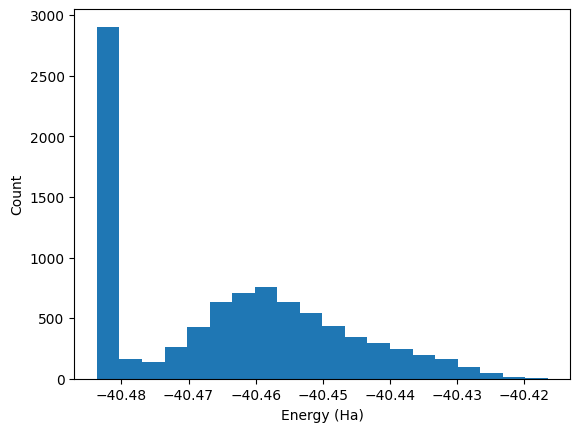

In [2]:
# Q1.A. Data preprocessing

# load data using pandas
data_file = 'https://raw.githubusercontent.com/ChemAI-Lab/Math4Chem/main/website/Assigments/CH4_data.csv'
data = pd.read_csv(data_file)
data.head()

# 1. How many points does the dataset contains?
n = data.shape[0]
print('The dataset contains {} points.'.format(n))

# 2. What is the point with the lowest energy and what is its value?
lowest_energy = data['energy'].min()
lowest_energy_point = data[data['energy'] == lowest_energy]
print('The point with the lowest energy is {} with a value of {} eV.'.format(lowest_energy_point.iloc[0, 0], lowest_energy))

# 3. What is the range of energies in the dataset? The energy is reported in Hartrees
energy_range = data['energy'].max() - data['energy'].min()
print('The range of energies in the dataset is {} Ha.'.format(energy_range))

# 4. Do a histogram of the energy.
plt.hist(data['energy'], bins=20)
plt.xlabel('Energy (Ha)')
plt.ylabel('Count')
plt.show()


In [3]:
# Q1.B Data splitting for training and testing.
# code here, 
y_all = data['energy'].to_numpy()
print(y_all.shape)
X_all = data.drop(['energy', 'Unnamed: 0'], axis=1).to_numpy()
print(X_all.shape)

i0 = np.arange(0, len(X_all))
np.random.shuffle(i0)
i0_tr = i0[:100]
i0_tst = i0[100:100+500]

X_tr = X_all[i0_tr]
y_tr = y_all[i0_tr]
y_tst = y_all[i0_tst]
X_tst = X_all[i0_tst]

print(X_tr.shape,y_tr.shape)
print(X_tst.shape,y_tst.shape)

(9000,)
(9000, 30)
(100, 30) (100,)
(500, 30) (500,)


In [4]:
def mean_square_error(X, y, w):
    y_pred = X @ w
    error = y_pred - y
    error_sqr = error**2
    return 0.5 * np.mean(error_sqr)

In [5]:
def s2_score(y_true,y_pred):
    y_mean = np.mean(y_true)
    ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_true - y_mean) ** 2)  # Total sum of squares
    r2 = 1 - (ss_res / ss_tot)
    return r2
def r2_plot(X_tr,y_tr, X_tst, y_tst, w):
    
    _, axs = plt.subplots(1, 2, figsize=(12, 5))
    y_tr_pred = X_tr@w
    y_tst_pred = X_tst@w
    diagonal = np.linspace(min(y_tr.min(), y_tr_pred.min()),
                           max(y_tr.max(), y_tr_pred.max()), 100)
    axs[0].scatter(y_tr, y_tr_pred, label='Training data')
    axs[0].plot(diagonal,diagonal,color='k')
    axs[0].text(0.7, 0.1, r'$r^{2}$ = ' + f'{s2_score(y_tr, y_tr_pred):.3f}',
                transform=axs[0].transAxes, fontsize=16)
    axs[0].text(0.05, 0.9, 'Training Data',
                transform=axs[0].transAxes, fontsize=12)
    
    diagonal = np.linspace(min(y_tst.min(), y_tst_pred.min()),
                           max(y_tst.max(), y_tst_pred.max()), 100)
    axs[1].plot(diagonal,diagonal,color='k')
    axs[1].scatter(y_tst, y_tst_pred, label='Test data')
    axs[1].text(0.7, 0.1, r'$r^{2}$ = ' + f'{s2_score(y_tst, y_tst_pred):.3f}',
                transform=axs[1].transAxes, fontsize=16)
    axs[1].text(0.05, 0.9, 'Test Data',
                transform=axs[1].transAxes, fontsize=12)

    axs[0].set_xlabel('Energy (Ha)')
    axs[1].set_xlabel('Energy (Ha)')
    axs[0].set_ylabel('Predicted energy (Ha)')
    plt.show()

MSE (Training data): 1.0397297678399597e-07
MSE (Test data): 5.319968877373256e-07


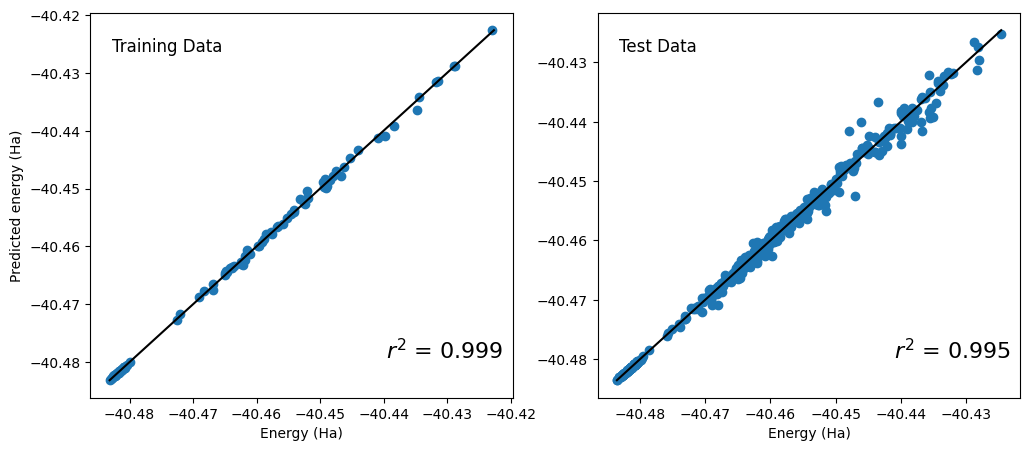

In [6]:
# Q1.C Exact solution of Linear Regression
# code here
def exact_solution_of_linear_regression(X, y):
    A = X.T @ X
    A_inv = np.linalg.inv(A)
    z = X.T @ y
    w_opt = A_inv@z
    return w_opt

w_lr = exact_solution_of_linear_regression(X_tr, y_tr)
print('MSE (Training data):', mean_square_error(X_tr, y_tr, w_lr))
print('MSE (Test data):', mean_square_error(X_tst, y_tst,w_lr))
r2_plot(X_tr, y_tr, X_tst, y_tst, w_lr)

0 MSE (Training data): 546.0958109447431
100 MSE (Training data): 0.006027027005142076
200 MSE (Training data): 0.005956959647966034
300 MSE (Training data): 0.005887716984852409
400 MSE (Training data): 0.00581928930804554
500 MSE (Training data): 0.0057516670240636515
600 MSE (Training data): 0.005684840652352117
700 MSE (Training data): 0.005618800823956633
800 MSE (Training data): 0.005553538280208378
900 MSE (Training data): 0.005489043871424951
1000 MSE (Training data): 0.005425308555628993
1100 MSE (Training data): 0.005362323397278854
1200 MSE (Training data): 0.005300079566017582
1300 MSE (Training data): 0.005238568335432533
1400 MSE (Training data): 0.0051777810818335775
1500 MSE (Training data): 0.0051177092830431
1600 MSE (Training data): 0.005058344517200896
1700 MSE (Training data): 0.004999678461584412
1800 MSE (Training data): 0.004941702891439914
1900 MSE (Training data): 0.0048844096788312336
2000 MSE (Training data): 0.004827790791498433
2100 MSE (Training data): 0.

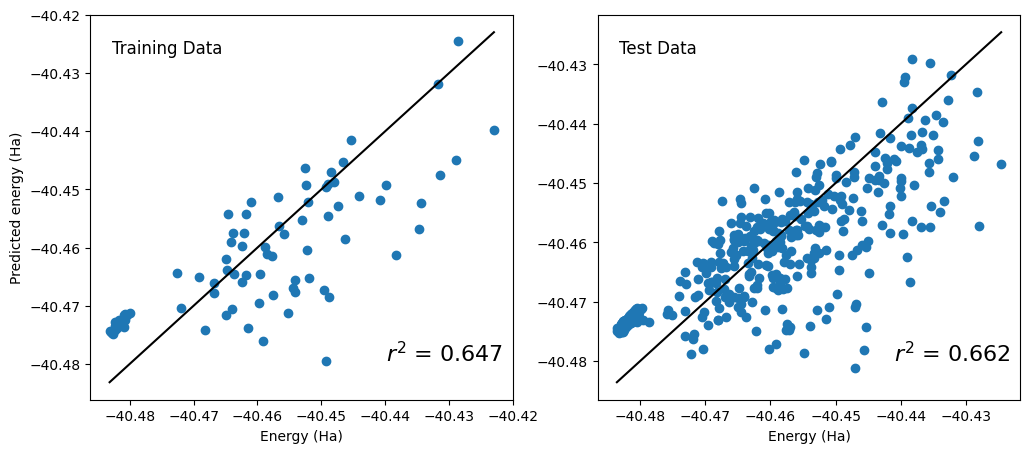

In [7]:
# Q1.C Gradient descent for Linear Regression
# code here
def gradient_descent_step(X, y, w0, eta):
    gw = -X.T @ y + X.T@X@w0
    gw = gw#/X.shape[0]
    return w0 - eta*gw


eta = 2E-3
n_iterations = 1000000
w0 = np.ones_like(X_tr[1, :])
# w0 = np.random.uniform(-1000,1000,size=(X_tr.shape[1],))
# w0 = w_lr + np.random.uniform(-10, 10, size=(X_tr.shape[1],))
mse_history = []
for i in range(n_iterations+1):
    w0 = gradient_descent_step(X_tr, y_tr, w0, eta)
    if i % 100 == 0:
        print(i, 'MSE (Training data):', mean_square_error(X_tr, y_tr, w0))
    mse_i = mean_square_error(X_tr, y_tr, w0)
    mse_history.append(mse_i)
print('--------------------------------')
print('MSE (Test data):', mean_square_error(X_tst, y_tst, w0))
w_gd = w0
r2_plot(X_tr, y_tr, X_tst, y_tst, w_gd)

MSE (Training data): 1.0397297678399597e-07
MSE (Test data): 5.319968877373256e-07


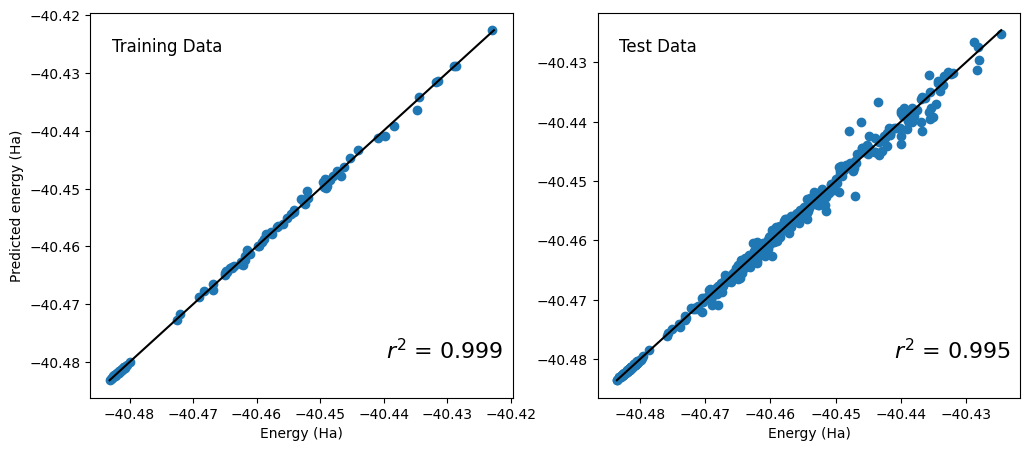

In [8]:
# Q1.C SVD for Linear Regression
# code here
def SVD_linear_regression(X,y):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    S_inv = np.diag(1 / S)
    A_pinv = Vt.T @ S_inv @ U.T
    w_opt = A_pinv @ y
    return w_opt

w_svd = SVD_linear_regression(X_tr, y_tr)
print('MSE (Training data):', mean_square_error(X_tr, y_tr, w_lr))
print('MSE (Test data):', mean_square_error(X_tst, y_tst, w_lr))
r2_plot(X_tr, y_tr, X_tst, y_tst, w_svd)

(30,)
(30,)
(30,)


Text(0.5, 0, 'Index')

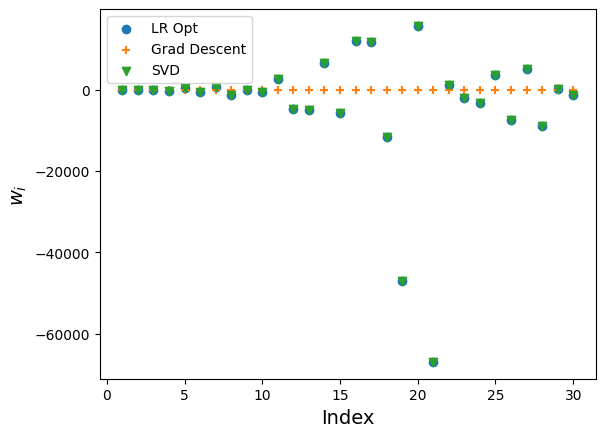

In [9]:
w_all = [w_lr,w_gd,w_svd]
label_ = ['LR Opt', 'Grad Descent', 'SVD']
symbol_ = ['o','+','v']
color_ = ['tab:blue','tab:orange','tab:green']

for li, ci, si, wi in zip(label_,color_,symbol_, w_all):
    print(wi.shape)
    # if si == '+':
    plt.scatter(np.arange(0,len(wi))+1, wi, marker=si, color=ci, label=li)
    
plt.legend()
plt.ylabel(r'$w_i$',fontsize=14)
plt.xlabel('Index', fontsize=14)

# (Q2) Newton's method for Nonlinear set of equations

Let's consider the following reactions,
$$
ScF_3(s) \to Sc^{3+}(aq) + 3F^{-}(aq), \;\; K_{sp} = 4.2\times10^{-18}\\
HF(aq) + H_2O \to H_3O^{+}(aq) + F^{-}(aq), \;\; K_{a} = 5.6\times10^-4\\
2H_2O \to H_3O^{+} + OH^{-}(aq), \;\; K_w = 10^{-14}
$$


We can write the concentration values for each species at equilibrium using three main variables, $\mathbf{x}^\top = [x_{sp},x_{a},x_{w}]$.
These give us the following relations,
$$
K_{sp} = x_{sp}(3x_{sp}+ x_a)^3 \\
K_{a} = \frac{(x_{a}+x_w)(3x_{sp} + x_a)}{-x_a} \\
K_w = (x_a+x_w)(x_w)
$$

You can use the following initial values for each species, 
1. $x_{sp} = 2\times^{-5}$
2. $x_a = -6.2\times^{-4}$
3. $x_w = 6.2\times^{-4}$
   
```x0 = np.array([2E-5,-6.2E-4,62E-4])```. <br>

 <br>
 
**Results to include,**
1. Implement the Vector function to find $\mathbf{x}^\top = [x_{sp},x_{a},x_{w}]$.
2. Implement the Jacobian function.
3. Implement the Newton's method step function. 
4. Figure illustrating the value of the three concentrations as a function of the iterations in Newton's method. 
5. The value of the concentrations. 
6. How many iterations are required for the concentration to change less than 1E-4 from the previous iteration.
7. Check if the answer of Newton's method depends on the initial value of the concentrations, you can use ```x0 = np.random.uniform(1E-5,1E-3,(3,))```, to generate some random initial guess.


In [19]:
def equations_of_motion(x, k):
    xsp = x[0]
    xa = x[1]
    xw = x[2]
    ksp = k[0]
    ka = k[1]
    kw = k[2]

    f1 = -ksp + xsp*(3*xsp+xa)**3
    f2 = ka*xa + (xa+xw)*(3*xsp+xa)
    f3 = -kw + (xa+xw)*(xw)
    return np.array([f1, f2, f3])


def jacobian_of_equations_of_motion(x, k):
    xsp = x[0]
    xa = x[1]
    xw = x[2]
    ksp = k[0]
    ka = k[1]
    kw = k[2]

    z0 = 3*xsp+xa
    z1 = xw + xa
    J = np.array([[9*(z0**2) + z0**3, 3*xsp*z0**2, 0],
                  [3*(z1), ka + 3*xsp + 2*xa + xw, z0],
                  [0, xw, xa + 2*xw]])
    return J


def newton_step(x0, k):
    f_values = equations_of_motion(x0, k)
    jac = jacobian_of_equations_of_motion(x0, k)
    jac_inv = np.linalg.inv(jac)
    x = x0 - jac_inv@(f_values)
    return x

In [26]:
k = np.array([4.2E-18, 5.6E-4, 1E-14])
x0 = np.array([2E-5, -6.2E-4, 62E-4])

# code here for the iteration of Newton's method
x0_trajectory = []
for i in range(20):
    x0 = newton_step(x0, k)
    print(f'Iteration {i+1}: {x0}')
    x0_trajectory.append(x0.copy())
x0_trajectory = np.array(x0_trajectory)

Iteration 1: [ 1.99991722e-05 -3.08942275e-04  3.09944330e-03]
Iteration 2: [ 1.99986973e-05 -1.53606111e-04  1.54926645e-03]
Iteration 3: [ 1.99984426e-05 -7.62046688e-05  7.74318431e-04]
Iteration 4: [ 1.99999987e-05 -3.77886288e-05  3.86994252e-04]
Iteration 5: [ 2.00007685e-05 -1.87814117e-05  1.93437791e-04]
Iteration 6: [ 2.00008888e-05 -9.36572832e-06  9.67057964e-05]
Iteration 7: [ 2.00009270e-05 -4.67977693e-06  4.83513304e-05]
Iteration 8: [ 2.00009410e-05 -2.33969420e-06  2.41756718e-05]
Iteration 9: [ 2.00009454e-05 -1.16986120e-06  1.20880606e-05]
Iteration 10: [ 2.00009455e-05 -5.84973864e-07  6.04448772e-06]
Iteration 11: [ 2.00009437e-05 -2.92574688e-07  3.02315923e-06]
Iteration 12: [ 2.00009409e-05 -1.46463707e-07  1.51341028e-06]
Iteration 13: [ 2.00009377e-05 -7.35850130e-08  7.60362490e-07]
Iteration 14: [ 2.00009342e-05 -3.74962611e-08  3.87461197e-07]
Iteration 15: [ 2.00009306e-05 -2.01299933e-08  2.08017342e-07]
Iteration 16: [ 2.00009270e-05 -1.26396163e-08  1

Text(0, 0.5, '$x_i$')

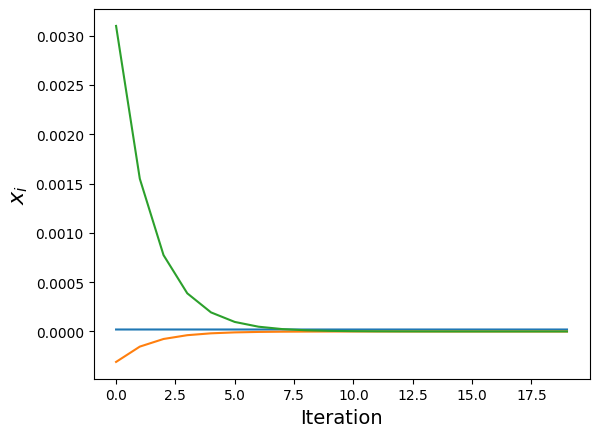

In [21]:
# Q2 Results
# 4. Figure illustrating the value of the three concentrations as a function of the iterations in Newton's method. 

plt.plot(np.arange(0,x0_trajectory.shape[0]),x0_trajectory)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel(r'$x_i$',fontsize=16)

In [22]:
# 5. The value of the concentrations.
for i, xi in enumerate(x0_trajectory[-1]):
    print('Concentration ', i, ' is ', xi)

# 6. How many iterations are required for the concentration to change less than 1E-4 from the previous iteration.
print('Approximately 10 interations are required')

# 7. Check if the answer of Newton's method depends on the initial value of the concentrations, you can use ```x0 = np.random.uniform(1E-5,1E-3,(3,))```, to generate some random initial guess.
print('There is a slight difference between the initial guess and the random initial guess')

Concentration  0  is  2.000091231852168e-05
Concentration  1  is  -1.0181461210546068e-08
Concentration  2  is  1.052202244524681e-07
Approximately 10 interations are required
There is a slight difference between the initial guess and the random initial guess


In [23]:
k = np.array([4.2E-18, 5.6E-4, 1E-14])
# x0 = np.array([2E-5, -6.2E-4, 62E-4])
x0 = np.random.uniform(1E-5, 1E-3, (3,))

# code here for the iteration of Newton's method
x1_trajectory = []
for i in range(50):
    x0 = newton_step(x0, k)
    print(f'Iteration {i+1}: {x0}')
    x1_trajectory.append(x0.copy())
x1_trajectory = np.array(x1_trajectory)

print(x0_trajectory[-1])
print(x1_trajectory[-1])

Iteration 1: [ 0.00084604 -0.00025212  0.00040451]
Iteration 2: [ 0.00084582 -0.00021777  0.00026887]
Iteration 3: [ 0.00084557 -0.00011278  0.00013771]
Iteration 4: [ 8.45328055e-04 -5.64125804e-05  6.88733637e-05]
Iteration 5: [ 8.45087278e-04 -2.82020439e-05  3.44332091e-05]
Iteration 6: [ 8.44847963e-04 -1.40993260e-05  1.72154144e-05]
Iteration 7: [ 8.44609445e-04 -7.04979997e-06  8.60831501e-06]
Iteration 8: [ 8.44371393e-04 -3.52693718e-06  4.30686600e-06]
Iteration 9: [ 8.44133642e-04 -1.76842157e-06  2.15959244e-06]
Iteration 10: [ 8.43896108e-04 -8.94527380e-07  1.09245112e-06]
Iteration 11: [ 8.43658752e-04 -4.67872308e-07  5.71422816e-07]
Iteration 12: [ 8.43421555e-04 -2.73431809e-07  3.33963268e-07]
Iteration 13: [ 8.43184508e-04 -2.04322423e-07  2.49563458e-07]
Iteration 14: [ 8.42947603e-04 -1.92621771e-07  2.35280893e-07]
Iteration 15: [ 8.42710834e-04 -1.92237875e-07  2.34823241e-07]
Iteration 16: [ 8.42474198e-04 -1.92205719e-07  2.34795900e-07]
Iteration 17: [ 8.422

# Q3 Molecular orbitals and Diagonalization

# Hückel model
As we saw in class, the Hückel model is one of the most basic models to describe the interaction between electrons in a molecule. <br>
The Hückel model is based on the following assumptions:
1. Only next-nearest neighbors atoms form bonds and if so $S_ij = 1$, else $S_ij = 0$.
2. The matrix elements of the Hamiltonian are described depending on the type of atom. <br>
   We will follow the notation of the paper, [A Pariser-Parr-Pople-based set of Hueckel molecular orbital parameters](https://pubs.acs.org/doi/abs/10.1021/jo01311a060), <br>
   where the diagonal elements ($h_i$) and off-diagonal elements ($h_{ij}$) are given by, 
    $$
    h_{i} = \alpha_0 + h_{X} \beta_0 \\
    h_{ij} = h_{X,Y} \beta_0 \\
    $$
Table 1 and 2 from [paper](https://pubs.acs.org/doi/abs/10.1021/jo01311a060) have those respected values. 
1. Table 1 $\to$ $h_i$ for different types of atoms.
2. Table 2 $\to$ $ h_{X,Y}$ for different types of atoms, $X$ and $Y$ are the index for the type of atoms that form a bond. 

**Results to include,**
1. What is the **HOMO-LUMO** value for Benzene.
2. Plot HOMO or LUMO orbital using the ```plot_benzene_with_lcao_circles()``` function.
   

In [18]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Define the benzene molecule coordinates


def benzene_positions():
    # 6 evenly spaced points around a circle
    theta = np.linspace(0, 2 * np.pi, 7)[:-1]
    radius = 1.0
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return np.array([x, y]).T

# Plot benzene with LCAO magnitudes


def plot_benzene_with_lcao_circles(magnitudes):
    positions = benzene_positions()
    # magnitudes = generate_lcao_magnitudes()

    # Normalize magnitudes for color mapping
    norm = Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
    colormap = plt.cm.viridis

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    # Plot benzene structure
    for i in range(len(positions)):
        ax.plot(
            [positions[i, 0], positions[(i + 1) % len(positions), 0]],
            [positions[i, 1], positions[(i + 1) % len(positions), 1]],
            'k-', lw=2
        )

    # Plot circles for each carbon atom
    for pos, mag in zip(positions, magnitudes):
        color = colormap(norm(mag))
        circle = plt.Circle(pos, radius=0.2, color=color,
                            edgecolor='black', lw=1)
        ax.add_artist(circle)
        ax.text(pos[0], pos[1], f"{mag:.2f}", fontsize=8,
                ha='center', va='center', color='white')

    # Add colorbar
    sm = ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array(magnitudes)
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label("Magnitude of LCAO")

    # Adjust plot limits and labels
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.axis('off')
    plt.title("Benzene with LCAO Magnitudes (Circles by Magnitude)")
    plt.show()